In [1]:
import numpy as np
import pandas as pd
import requests
import json 
from tqdm import tqdm
import pickle
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import matplotlib.pyplot as plt
import sklearn
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from tqdm import tqdm

import random
from xgboost import XGBClassifier, XGBRegressor, plot_importance, plot_tree
import xgboost as xgb

from sklearn.metrics import mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression

from sklearn.ensemble import RandomForestClassifier

from sklearn.svm import SVC

from scipy import integrate

from mpl_toolkits.basemap import Basemap

import seaborn as sb

In [2]:
contacts = pd.read_csv('C:\\Users\\mznid\\Downloads\\datasets\\Marketing_Analytics_Datasets\\DMEFExtractContactsV01.CSV')

customers = pd.read_csv('C:\\Users\\mznid\\Downloads\\datasets\\Marketing_Analytics_Datasets\\DMEFExtractSummaryV01.CSV')

orders = pd.read_csv('C:\\Users\\mznid\\Downloads\\datasets\\Marketing_Analytics_Datasets\\DMEFExtractLinesV01.CSV')

contacts = pd.read_csv('C:\\Users\\mznid\\Downloads\\datasets\\Marketing_Analytics_Datasets\\DMEFExtractContactsV01.CSV')

In [3]:
contactsaggregate = contacts.groupby(['Cust_ID','ContactType']).count().reset_index()

print(contactsaggregate)

         Cust_ID ContactType  ContactDate
0          22120           C           21
1          24436           C            1
2          24436           E          123
3          29278           C            9
4          50011           E          119
...          ...         ...          ...
103210  91216829           E            1
103211  91217064           E            1
103212  91218539           E            1
103213  91222126           E            1
103214  91223018           E            1

[103215 rows x 3 columns]


In [4]:
droplist = []
for ind1, each in contactsaggregate.iterrows():
    for ind2, every in enumerate(each):
        if every == ' ':
            droplist.append(ind1)

keeplist = list(set(list(range(0, len(contactsaggregate.iloc[:,0])))) - set(droplist))

In [5]:
contactsaggregateNONULLS = contactsaggregate.iloc[keeplist,:]

# losing about 40000 rows of order granularity

contactsaggregateNONULLS.sort_values(by=['Cust_ID'], ascending = True)

,Cust_ID,ContactType,ContactDate
0,22120,C,21
1,24436,C,1
2,24436,E,123
3,29278,C,9
4,50011,E,119
...,...,...,...
103210,91216829,E,1
103211,91217064,E,1
103212,91218539,E,1
103213,91222126,E,1


In [6]:
print(set(contactsaggregateNONULLS.loc[:,'ContactType']))

{'C', 'E'}


In [7]:
contactsaggregateNONULLS.loc[contactsaggregateNONULLS.Cust_ID == 22120,'ContactDate']

0    21
Name: ContactDate, dtype: int64

In [8]:
contactcustomerlist = list(set(contactsaggregateNONULLS.loc[:,'Cust_ID']))

In [9]:
customerdict = {'Cust_ID':[],'CATALOGoutreach':[],'EMAILoutreach':[]}

for each in tqdm(contactcustomerlist):
    subset = contactsaggregateNONULLS.loc[contactsaggregateNONULLS.Cust_ID == each,:].reset_index()
    
    C = 0
    E = 0
    
    if len(subset.iloc[:,0]) > 0:
        for every in range(0,len(subset.iloc[:,0])):
            if subset.loc[every,'ContactType'] == 'C':
                C = subset.loc[every,'ContactDate']
            elif subset.loc[every,'ContactType'] == 'E':
                E = subset.loc[every,'ContactDate']
        
        customerdict['Cust_ID'] += [subset.loc[0,'Cust_ID']]
        customerdict['CATALOGoutreach'] += [C]
        customerdict['EMAILoutreach'] += [E]

        
newdf = pd.DataFrame(customerdict)

newdf


100%|███████████████████████████████████████████████████████████████████████████| 80421/80421 [01:23<00:00, 964.06it/s]


,Cust_ID,CATALOGoutreach,EMAILoutreach
0,90701829,0,3
1,44302344,40,129
2,78381065,8,0
3,88080399,2,9
4,67633169,22,0
...,...,...,...
80416,61603819,1,0
80417,81526772,1,0
80418,63700985,8,0
80419,54001660,33,0


In [10]:
customers.loc[:,['LengthRes','AgeCode','Dwelling', 'HomeCode', 'IncCode']]

,LengthRes,AgeCode,Dwelling,HomeCode,IncCode
0,8,4,1,2,8
1,3,,,,
2,2,7,2,2,9
3,,,,,
4,,,,,
...,...,...,...,...,...
100046,6,3,2,2,7
100047,,,,,
100048,,,,,
100049,,,,,


In [11]:
for ind, each in tqdm(customers.iterrows()):
    try:
        if float(customers.loc[ind,'SCF_Code']) < 100.:
            customers.loc[ind, 'SCF_Code'] = '0' + str(customers.loc[ind,'SCF_Code'])
    except:
        pass

100051it [00:15, 6662.35it/s]


In [12]:
customers = customers.loc[:,[
    'Cust_ID',
    'FirstChannel', 'FirstDollar'
    ,'SCF_Code'
    ,'FirstYYMM'
    ,'StoreDist'
    ,'AcqDate'
    
    ,'LengthRes','AgeCode','Dwelling', 'HomeCode', 'IncCode'   # moderately null ordinals except for homecode which is binary
    
    ,'Email'
    
    ,'Sewing','Travel','Hunting','FineArts','CarOwner','Collect','Needle','DogOwner','Cooking','CurrAff','CurrEv','Pets','Fashion','Camping','Boating', 'Wines', 'Exercise','SelfHelp'
    
    ,'Child0_2','Child3_5','Child6_11','Child12_16','Child17_18'
    

    
    ,'RetF07Dollars','RetS07Dollars','RetF06Dollars','RetS06Dollars','RetF05Dollars','RetS05Dollars','RetF04Dollars','RetS04Dollars','RetPre04Dollars'
    ,'RetF07Trips','RetS07Trips','RetF06Trips','RetS06Trips','RetF05Trips','RetS05Trips','RetF04Trips','RetS04Trips','RetPre04Trips'
    ,'RetF07Lines','RetS07Lines','RetF06Lines','RetS06Lines','RetF05Lines','RetS05Lines','RetF04Lines','RetS04Lines','RetPre04Lines'
    
    ,'IntF07GDollars','IntS07GDollars','IntF06GDollars','IntS06GDollars','IntF05GDollars','IntS05GDollars','IntF04GDollars','IntS04GDollars','IntPre04GDollars'
    ,'IntF07NGDollars','IntS07NGDollars','IntF06NGDollars','IntS06NGDollars','IntF05NGDollars','IntS05NGDollars','IntF04NGDollars','IntS04NGDollars','IntPre04NGDollars'
    ,'IntF07Orders','IntS07Orders','IntF06Orders','IntS06Orders','IntF05Orders','IntS05Orders','IntF04Orders','IntS04Orders','IntPre04Orders'
    ,'IntF07Lines','IntS07Lines','IntF06Lines','IntS06Lines','IntF05Lines','IntS05Lines','IntF04Lines','IntS04Lines','IntPre04Lines'
    
    ,'CatF07GDollars','CatS07GDollars','CatF06GDollars','CatS06GDollars','CatF05GDollars','CatS05GDollars','CatF04GDollars','CatS04GDollars','CatPre04GDollars'
    ,'CatF07NGDollars','CatS07NGDollars','CatF06NGDollars','CatS06NGDollars','CatF05NGDollars','CatS05NGDollars','CatF04NGDollars','CatS04NGDollars','CatPre04NGDollars'
    ,'CatF07Orders','CatS07Orders','CatF06Orders','CatS06Orders','CatF05Orders','CatS05Orders','CatF04Orders','CatS04Orders','CatPre04Orders'
    ,'CatF07Lines','CatS07Lines','CatF06Lines','CatS06Lines','CatF05Lines','CatS05Lines','CatF04Lines','CatS04Lines','CatPre04Lines'
    
    ]]

In [13]:
droplist = []
for ind1, each in customers.iterrows():
    for ind2, every in enumerate(each):
        if every == ' ':
            droplist.append(ind1)

keeplist = list(set(list(range(0, len(customers.iloc[:,0])))) - set(droplist))

In [14]:
customersfeatures = customers.iloc[keeplist,:]

In [15]:
def convertYNtoBinary(df, column):
    temp = []
    for each in df.loc[:,column]:
        if each == 'Y':
            temp.append(1)
        else:
            temp.append(0)
    #print(len(temp))
    df.loc[:,column] = pd.Series(temp, index = df.index)


for col in ['Email','Sewing','Travel','Hunting','FineArts','CarOwner','Collect','Needle','DogOwner','Cooking','CurrAff','CurrEv','Pets','Fashion'
            ,'Camping','Boating', 'Wines', 'Exercise','SelfHelp','Child0_2','Child3_5','Child6_11','Child12_16','Child17_18']:
    convertYNtoBinary(customersfeatures, col)
    
    
customersfeatures.loc[:,'HomeCode'] = pd.Series([int(i) - 1 for i in customersfeatures.loc[:,'HomeCode']], index = customersfeatures.index)    

C:\Users\mznid\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [16]:
# I'VE PICKLED A DICTIONARY THAT WILL HELP CONVERT SCF_Code to GPS COORDINATES. THIS TOOK A LOT OF OBNOXIOUS WORK AND API STUFF SO I'VE EXCLUDED THAT PART OF THE CODE. 
SCFcoordinates = pickle.load( open( "C:\\Users\\mznid\\SCFcoordinates.p", "rb" ) )

In [17]:
gpsx = []
gpsy = []
for each in customersfeatures.loc[:,'SCF_Code']:
    if type(SCFcoordinates[each]) == float:        # checks for NaNs, a few SCF_Codes didn't have addresses and so were assigned NaN coordinates. we could fix this manually if we want
        gpsx.append(SCFcoordinates[each])
        gpsy.append(SCFcoordinates[each])
    else:
        gpsx.append(SCFcoordinates[each]['results'][0]['geometry']['viewport']['northeast']['lng'])          # northeast or southwest????
        gpsy.append(SCFcoordinates[each]['results'][0]['geometry']['viewport']['northeast']['lat'])    

customersfeatures.loc[:,'gpsX'] = pd.Series(gpsx, index = customersfeatures.index)
customersfeatures.loc[:,'gpsY'] = pd.Series(gpsy, index = customersfeatures.index)

customersfeatures = customersfeatures.drop(columns = ['SCF_Code'])

C:\Users\mznid\Anaconda3\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)


In [18]:
customersfeatures = customersfeatures.dropna()

In [19]:
iddict = {}
for each in customersfeatures.loc[:,'FirstChannel']:
    if each not in iddict:
        iddict[each] = len(iddict)

verification_status = [iddict[i] for i in customersfeatures.loc[:,'FirstChannel']]

inverseiddict = dict(map(reversed, iddict.items()))

verification_statusdf = pd.DataFrame(to_categorical(verification_status), columns = [inverseiddict[0],inverseiddict[1],inverseiddict[2]], index = customersfeatures.index)

customersfeatures = customersfeatures.drop(columns=['FirstChannel'])

In [20]:
FirstInYears = []
for each in customersfeatures.loc[:,'FirstYYMM']:
    temp = int(str(each)[:4]) + ((int(str(each)[-2:]) - 1) / 12)
    FirstInYears.append(temp)

customersfeatures.loc[:,'FirstYYMM'] = pd.Series(FirstInYears, index = customersfeatures.index)

In [21]:
AcqDateInYears = []
for each in customersfeatures.loc[:,'AcqDate']:
    temp = int(str(each)[:4]) + ((int(str(each)[-2:]) - 1) / 12)
    AcqDateInYears.append(temp)

customersfeatures.loc[:,'AcqDate'] = pd.Series(AcqDateInYears, index = customersfeatures.index)

In [22]:
# loc works different from iloc... passing an integer to index will look for the index name, not position, so resent index:
customersfeatures = customersfeatures.reset_index()



RETAILdollarstotal = customersfeatures.loc[:,['RetF07Dollars','RetS07Dollars','RetF06Dollars','RetS06Dollars','RetF05Dollars','RetS05Dollars','RetF04Dollars','RetS04Dollars','RetPre04Dollars']].sum(axis=1)
INTERNETdollarstotal = customersfeatures.loc[:,['IntF07GDollars','IntS07GDollars','IntF06GDollars','IntS06GDollars','IntF05GDollars','IntS05GDollars','IntF04GDollars','IntS04GDollars','IntPre04GDollars','IntF07NGDollars','IntS07NGDollars','IntF06NGDollars','IntS06NGDollars','IntF05NGDollars','IntS05NGDollars','IntF04NGDollars','IntS04NGDollars','IntPre04NGDollars']].sum(axis=1)
CATALOGdollarstotal = customersfeatures.loc[:,['CatF07GDollars','CatS07GDollars','CatF06GDollars','CatS06GDollars','CatF05GDollars','CatS05GDollars','CatF04GDollars','CatS04GDollars','CatPre04GDollars','CatF07NGDollars','CatS07NGDollars','CatF06NGDollars','CatS06NGDollars','CatF05NGDollars','CatS05NGDollars','CatF04NGDollars','CatS04NGDollars','CatPre04NGDollars']].sum(axis=1)


RETAILtripstotal = customersfeatures.loc[:,['RetF07Trips','RetS07Trips','RetF06Trips','RetS06Trips','RetF05Trips','RetS05Trips','RetF04Trips','RetS04Trips','RetPre04Trips']].sum(axis=1)
INTERNETorderstotal = customersfeatures.loc[:,['IntF07Orders','IntS07Orders','IntF06Orders','IntS06Orders','IntF05Orders','IntS05Orders','IntF04Orders','IntS04Orders','IntPre04Orders']].sum(axis=1)
CATALOGorderstotal = customersfeatures.loc[:,['CatF07Orders','CatS07Orders','CatF06Orders','CatS06Orders','CatF05Orders','CatS05Orders','CatF04Orders','CatS04Orders','CatPre04Orders']].sum(axis=1)


RETAILitemstotal = customersfeatures.loc[:,['RetF07Lines','RetS07Lines','RetF06Lines','RetS06Lines','RetF05Lines','RetS05Lines','RetF04Lines','RetS04Lines','RetPre04Lines']].sum(axis=1)
INTERNETitemstotal = customersfeatures.loc[:,['IntF07Lines','IntS07Lines','IntF06Lines','IntS06Lines','IntF05Lines','IntS05Lines','IntF04Lines','IntS04Lines','IntPre04Lines']].sum(axis=1)
CATALOGitemstotal = customersfeatures.loc[:,['CatF07Lines','CatS07Lines','CatF06Lines','CatS06Lines','CatF05Lines','CatS05Lines','CatF04Lines','CatS04Lines','CatPre04Lines']].sum(axis=1)



mostrecent = []
    
def checkrecency(i):
    for every in ['RetF07Dollars','IntF07GDollars','IntF07NGDollars','CatF07GDollars','CatF07NGDollars']:
        if customersfeatures.loc[i , every] > 0:
            return 'F07'
    for every in ['RetS07Dollars','IntS07GDollars','IntS07NGDollars','CatS07GDollars','CatS07NGDollars']:
        if customersfeatures.loc[i , every] > 0:
            return 'S07'
    for every in ['RetF06Dollars','IntF06GDollars','IntF06NGDollars','CatF06GDollars','CatF06NGDollars']:
        if customersfeatures.loc[i , every] > 0:
            return 'F06'
    for every in ['RetS06Dollars','IntS06GDollars','IntS06NGDollars','CatS06GDollars','CatS06NGDollars']:
        if customersfeatures.loc[i , every] > 0:
            return 'S06'
    for every in ['RetF05Dollars','IntF05GDollars','IntF05NGDollars','CatF05GDollars','CatF05NGDollars']:
        if customersfeatures.loc[i , every] > 0:
            return 'F05'
    for every in ['RetS05Dollars','IntS05GDollars','IntS05NGDollars','CatS05GDollars','CatS05NGDollars']:
        if customersfeatures.loc[i , every] > 0:
            return 'S05'
    for every in ['RetF04Dollars','IntF04GDollars','IntF04NGDollars','CatF04GDollars','CatF04NGDollars']:
        if customersfeatures.loc[i , every] > 0:
            return 'F04'
    for every in ['RetS04Dollars','IntS04GDollars','IntS04NGDollars','CatS04GDollars','CatS04NGDollars']:
        if customersfeatures.loc[i , every] > 0:
            return 'S04'
    for every in ['RetPre04Dollars','IntPre04GDollars','IntPre04NGDollars','CatPre04GDollars','CatPre04NGDollars']:
        if customersfeatures.loc[i , every] > 0:
            return 'Pre04'
    return 'NA'
    
for each in range(0,len(customersfeatures.iloc[:,0])):
    mostrecent.append(checkrecency(each))
    
for ind, every in enumerate(mostrecent):
    if every == 'F07':
        mostrecent[ind] = 2007. + ((12-1)/12)
    elif every == 'S07':
        mostrecent[ind] = 2007. + ((6-1)/12)
    elif every == 'F06':
        mostrecent[ind] = 2006. + ((12-1)/12)
    elif every == 'S06':
        mostrecent[ind] = 2006. + ((6-1)/12)
    elif every == 'F05':
        mostrecent[ind] = 2005. + ((12-1)/12)
    elif every == 'S05':
        mostrecent[ind] = 2005. + ((6-1)/12)
    elif every == 'F04':
        mostrecent[ind] = 2004. + ((12-1)/12)
    elif every == 'S04':
        mostrecent[ind] = 2004. + ((6-1)/12)
    elif every == 'Pre04':
        mostrecent[ind] = 2003. + ((12-1)/12)
    elif every == 'NA':
        mostrecent[ind] = 2003. + ((12-1)/12)


In [23]:
RetailTotalsOverTime = customersfeatures.loc[:,['RetF07Dollars','RetS07Dollars','RetF06Dollars','RetS06Dollars','RetF05Dollars','RetS05Dollars','RetF04Dollars','RetS04Dollars','RetPre04Dollars']].sum(axis=0)
InternetGiftTotalsOverTime = customersfeatures.loc[:,['IntF07GDollars','IntS07GDollars','IntF06GDollars','IntS06GDollars','IntF05GDollars','IntS05GDollars','IntF04GDollars','IntS04GDollars','IntPre04GDollars']].sum(axis=0)
CatalogGiftTotalsOverTime = customersfeatures.loc[:,['CatF07GDollars','CatS07GDollars','CatF06GDollars','CatS06GDollars','CatF05GDollars','CatS05GDollars','CatF04GDollars','CatS04GDollars','CatPre04GDollars']].sum(axis=0)
InternetNotGiftTotalsOverTime = customersfeatures.loc[:,['IntF07NGDollars','IntS07NGDollars','IntF06NGDollars','IntS06NGDollars','IntF05NGDollars','IntS05NGDollars','IntF04NGDollars','IntS04NGDollars','IntPre04NGDollars']].sum(axis=0)
CatalogNotGiftTotalsOverTime = customersfeatures.loc[:,['CatF07NGDollars','CatS07NGDollars','CatF06NGDollars','CatS06NGDollars','CatF05NGDollars','CatS05NGDollars','CatF04NGDollars','CatS04NGDollars','CatPre04NGDollars']].sum(axis=0)

In [24]:
RetailTotalsOverTime = pd.Series(np.array(RetailTotalsOverTime), index = ['Fall 2007','Spring 2007','Fall 2006','Spring 2006','Fall 2005','Spring 2005','Fall 2004','Spring 2004','2001-2003'])
InternetTotalsOverTime = pd.Series(np.add(np.array(InternetGiftTotalsOverTime) , np.array(InternetNotGiftTotalsOverTime)), index = ['Fall 2007','Spring 2007','Fall 2006','Spring 2006','Fall 2005','Spring 2005','Fall 2004','Spring 2004','2001-2003'])
CatalogTotalsOverTime = pd.Series(np.add(np.array(CatalogGiftTotalsOverTime) , np.array(CatalogNotGiftTotalsOverTime)), index = ['Fall 2007','Spring 2007','Fall 2006','Spring 2006','Fall 2005','Spring 2005','Fall 2004','Spring 2004','2001-2003'])

In [25]:
customersfeatures.loc[:,'mostrecent'] = pd.Series(mostrecent, index = customersfeatures.index)

customersfeatures.loc[:,'RETAILdollarstotal'] = pd.Series(RETAILdollarstotal, index = customersfeatures.index)
customersfeatures.loc[:,'INTERNETdollarstotal'] = pd.Series(INTERNETdollarstotal, index = customersfeatures.index)
customersfeatures.loc[:,'CATALOGdollarstotal'] = pd.Series(CATALOGdollarstotal, index = customersfeatures.index)
customersfeatures.loc[:,'RETAILtripstotal'] = pd.Series(RETAILtripstotal, index = customersfeatures.index)
customersfeatures.loc[:,'INTERNETorderstotal'] = pd.Series(INTERNETorderstotal, index = customersfeatures.index)
customersfeatures.loc[:,'CATALOGorderstotal'] = pd.Series(CATALOGorderstotal, index = customersfeatures.index)
customersfeatures.loc[:,'RETAILitemstotal'] = pd.Series(RETAILitemstotal, index = customersfeatures.index)
customersfeatures.loc[:,'INTERNETitemstotal'] = pd.Series(INTERNETitemstotal, index = customersfeatures.index)
customersfeatures.loc[:,'CATALOGitemstotal'] = pd.Series(CATALOGitemstotal, index = customersfeatures.index)

In [26]:
RETAILproportion = pd.Series(RETAILdollarstotal, index = customersfeatures.index) / (pd.Series(CATALOGdollarstotal, index = customersfeatures.index) + pd.Series(INTERNETdollarstotal, index = customersfeatures.index) + pd.Series(RETAILdollarstotal, index = customersfeatures.index))
INTERNETproportion = pd.Series(INTERNETdollarstotal, index = customersfeatures.index) / (pd.Series(CATALOGdollarstotal, index = customersfeatures.index) + pd.Series(RETAILdollarstotal, index = customersfeatures.index) + pd.Series(INTERNETdollarstotal, index = customersfeatures.index))
CATALOGproportion = pd.Series(CATALOGdollarstotal, index = customersfeatures.index) / (pd.Series(RETAILdollarstotal, index = customersfeatures.index) + pd.Series(INTERNETdollarstotal, index = customersfeatures.index) + pd.Series(CATALOGdollarstotal, index = customersfeatures.index))

customersfeatures.loc[:,'RETAILproportion'] = RETAILproportion
customersfeatures.loc[:,'INTERNETproportion'] = INTERNETproportion
customersfeatures.loc[:,'CATALOGproportion'] = CATALOGproportion


In [27]:
mincustomerlifetimeyears = customersfeatures['mostrecent'] - customersfeatures['FirstYYMM']
mincustomerlifetimeyears = mincustomerlifetimeyears + 0.5
customersfeatures.loc[:,'mincustomerlifetimeyears'] = pd.Series(mincustomerlifetimeyears, index = customersfeatures.index)
customersfeatures.loc[:,'mincustomerlifetimeyears']

0        2.500000
1        5.666667
2        1.500000
3        2.666667
4        2.666667
           ...   
46356    1.083333
46357    0.583333
46358    0.583333
46359    1.000000
46360    0.833333
Name: mincustomerlifetimeyears, Length: 46361, dtype: float64

In [28]:
# calculate customer purchase frequency

# I totally overengineered this whole thing, I can just sum the trips/order and divide by the lifetime I ALREADY CALCULATED

averagerecordedfrequency = []
'''
coltuplelist = [('RetPre04Dollars','IntPre04GDollars','IntPre04NGDollars','CatPre04GDollars','CatPre04NGDollars'),
                ('RetS04Dollars','IntS04GDollars','IntS04NGDollars','CatS04GDollars','CatS04NGDollars'),
                ('RetF04Dollars','IntF04GDollars','IntF04NGDollars','CatF04GDollars','CatF04NGDollars'),
                ('RetS05Dollars','IntS05GDollars','IntS05NGDollars','CatS05GDollars','CatS05NGDollars'),
                ('RetF05Dollars','IntF05GDollars','IntF05NGDollars','CatF05GDollars','CatF05NGDollars'),
                ('RetS06Dollars','IntS06GDollars','IntS06NGDollars','CatS06GDollars','CatS06NGDollars'),
                ('RetF06Dollars','IntF06GDollars','IntF06NGDollars','CatF06GDollars','CatF06NGDollars'),
                ('RetS07Dollars','IntS07GDollars','IntS07NGDollars','CatS07GDollars','CatS07NGDollars'),
                ('RetF07Dollars','IntF07GDollars','IntF07NGDollars','CatF07GDollars','CatF07NGDollars')
               ]
'''
coltuplelist = [('RetPre04Trips','IntPre04Orders','CatPre04Orders'),
               ('RetS04Trips','IntS04Orders','CatS04Orders'),
               ('RetF04Trips','IntF04Orders','CatF04Orders'),
               ('RetS05Trips','IntS05Orders','CatS05Orders'),
               ('RetF05Trips','IntF05Orders','CatF05Orders'),
               ('RetS06Trips','IntS06Orders','CatS06Orders'),
               ('RetF06Trips','IntF06Orders','CatF06Orders'),
               ('RetS07Trips','IntS07Orders','CatS07Orders'),
               ('RetF07Trips','IntF07Orders','CatF07Orders'),]


for ind in range(0,len(customersfeatures.iloc[:,0])):
    totalorderandtrips = 0
    for season in coltuplelist:
        a,b,c = season
        ordersandtrips = customersfeatures.loc[ind,a] + customersfeatures.loc[ind,b] + customersfeatures.loc[ind,c] 
        totalorderandtrips += ordersandtrips  
    averagefrequency = totalorderandtrips / customersfeatures.loc[ind,'mincustomerlifetimeyears']
    averagerecordedfrequency.append(averagefrequency)


In [29]:
print(customersfeatures.loc[:,['Cust_ID','mincustomerlifetimeyears','mostrecent','FirstYYMM']].sort_values(by=['Cust_ID']))

        Cust_ID  mincustomerlifetimeyears   mostrecent    FirstYYMM
0         22120                  2.500000  2006.916667  2004.916667
1        206591                  5.666667  2006.916667  2001.750000
2        260370                  1.500000  2003.916667  2002.916667
3        460711                  2.666667  2003.916667  2001.750000
4        484562                  2.666667  2004.916667  2002.750000
...         ...                       ...          ...          ...
46356  88238560                  1.083333  2007.916667  2007.333333
46357  88243948                  0.583333  2007.416667  2007.333333
46358  88246955                  0.583333  2007.416667  2007.333333
46359  88397121                  1.000000  2007.916667  2007.416667
46360  88530909                  0.833333  2007.916667  2007.583333

[46361 rows x 4 columns]


In [30]:
customersfeatures = customersfeatures = newdf.merge(customersfeatures, left_on = ['Cust_ID'], right_on = ['Cust_ID'],  how = 'right').fillna(0)

In [31]:
customersfeatures = customersfeatures.reset_index()
customersfeatures.shape

(46361, 153)

In [32]:
# FUTURE CLV = [$Margin - $Retentionspending] * [(1 + d) / (1 + d - r)]

d = 0.07
r = 0.8     # how do we estimate this?
cogs_multiplier = (1 - 0.7)     # we need to estimate   

# ASSUMPTIONS ABOUT COGS BASED ON CHANNEL?   
# COGSRETAILmultiplier = (1 - 0.7)
# COGSINTERNETmultiplier = (1 - 0.8)
# COGSCATALOGmultiplier = (1 - 0.8)

# retentionspending = 20    # dollars per customer per year estimate?

CatalogPrice = 2
EmailPrice = 0.1
avgfrequencymultiplier = 1.6

# assumedcustomerlossdate = 2006.0   # analyze the data to see what (lack of) recency makes sense
  
clvlist = []    
for ind, row in tqdm(customersfeatures.iterrows()):
    
    #totaldollarsafterCOGS = customersfeatures.loc[ind,'RETAILdollarstotal'] * COGSRETAILmultiplier + customersfeatures.loc[ind,'INTERNETdollarstotal'] * COGSINTERNETmultiplier + customersfeatures.loc[ind,'CATALOGdollarstotal'] * COGSCATALOGmultiplier
    totaldollars = customersfeatures.loc[ind,'RETAILdollarstotal'] + customersfeatures.loc[ind,'INTERNETdollarstotal'] + customersfeatures.loc[ind,'CATALOGdollarstotal']
    
    lifetime = customersfeatures.loc[ind,'mincustomerlifetimeyears']
    
    x2 = lambda x: (1 - d)**(x)      # check this equation
    integral , error = integrate.quad(x2, -lifetime, 0)
    
    discount_multiplier = integral / lifetime
    
    
    # Estimates cost of outreach materials per customer, and divides it by lifetime (should it be divided by FirstMMYY to present (2008) ?)
    retentionspending = (customersfeatures.loc[ind,'CATALOGoutreach'] * CatalogPrice + customersfeatures.loc[ind,'EMAILoutreach'] * EmailPrice) / lifetime
    
    
    
    #clv = totaldollars / lifetime    # average yearly lifetime value contribution
    
    
    clv = (((totaldollars * cogs_multiplier) * discount_multiplier) - (retentionspending * lifetime)) 
    
    # test if customer still active
    
    #if ind == 1:
    #    print((2008. - customersfeatures.loc[ind,'mostrecent']), (2.1 / averagerecordedfrequency[ind]) )  # numerator is how many "average intervals between purchases" must be surpassed before a customer is dead
    
    if (2008. - customersfeatures.loc[ind,'mostrecent']) < (avgfrequencymultiplier / averagerecordedfrequency[ind]):   # convert orders a year to years till order  # OH SHOOT DID I HAVE THE GREATER THAN SIGN THE WRONG WAY
        clv += (((totaldollars / lifetime) * cogs_multiplier) - retentionspending) * ((1 + d) / (1 + d - r))
    
     
    clvlist.append(clv)

customersfeatures.loc[:,'CLVestimate'] = pd.Series(clvlist, index = customersfeatures.index)

46361it [00:06, 7294.00it/s]


In [33]:
#customersfeatures.to_csv('C:\\Users\\mznid\\CUSTOMERSwithOUTREACHandCLV.csv')

In [34]:
customersfeatures = customersfeatures.drop(columns=['RetF07Dollars','RetS07Dollars','RetF06Dollars','RetS06Dollars','RetF05Dollars','RetS05Dollars','RetF04Dollars','RetS04Dollars','RetPre04Dollars'
                                                    ,'RetF07Trips','RetS07Trips','RetF06Trips','RetS06Trips','RetF05Trips','RetS05Trips','RetF04Trips','RetS04Trips','RetPre04Trips'
                                                    ,'RetF07Lines','RetS07Lines','RetF06Lines','RetS06Lines','RetF05Lines','RetS05Lines','RetF04Lines','RetS04Lines','RetPre04Lines'

                                                    ,'IntF07GDollars','IntS07GDollars','IntF06GDollars','IntS06GDollars','IntF05GDollars','IntS05GDollars','IntF04GDollars','IntS04GDollars','IntPre04GDollars'
                                                    ,'IntF07NGDollars','IntS07NGDollars','IntF06NGDollars','IntS06NGDollars','IntF05NGDollars','IntS05NGDollars','IntF04NGDollars','IntS04NGDollars','IntPre04NGDollars'
                                                    ,'IntF07Orders','IntS07Orders','IntF06Orders','IntS06Orders','IntF05Orders','IntS05Orders','IntF04Orders','IntS04Orders','IntPre04Orders'
                                                    ,'IntF07Lines','IntS07Lines','IntF06Lines','IntS06Lines','IntF05Lines','IntS05Lines','IntF04Lines','IntS04Lines','IntPre04Lines'

                                                    ,'CatF07GDollars','CatS07GDollars','CatF06GDollars','CatS06GDollars','CatF05GDollars','CatS05GDollars','CatF04GDollars','CatS04GDollars','CatPre04GDollars'
                                                    ,'CatF07NGDollars','CatS07NGDollars','CatF06NGDollars','CatS06NGDollars','CatF05NGDollars','CatS05NGDollars','CatF04NGDollars','CatS04NGDollars','CatPre04NGDollars'
                                                    ,'CatF07Orders','CatS07Orders','CatF06Orders','CatS06Orders','CatF05Orders','CatS05Orders','CatF04Orders','CatS04Orders','CatPre04Orders'
                                                    ,'CatF07Lines','CatS07Lines','CatF06Lines','CatS06Lines','CatF05Lines','CatS05Lines','CatF04Lines','CatS04Lines','CatPre04Lines'
                                                    ])

In [35]:
print(customersfeatures.columns)

Index(['level_0', 'Cust_ID', 'CATALOGoutreach', 'EMAILoutreach', 'index',
       'FirstDollar', 'FirstYYMM', 'StoreDist', 'AcqDate', 'LengthRes',
       'AgeCode', 'Dwelling', 'HomeCode', 'IncCode', 'Email', 'Sewing',
       'Travel', 'Hunting', 'FineArts', 'CarOwner', 'Collect', 'Needle',
       'DogOwner', 'Cooking', 'CurrAff', 'CurrEv', 'Pets', 'Fashion',
       'Camping', 'Boating', 'Wines', 'Exercise', 'SelfHelp', 'Child0_2',
       'Child3_5', 'Child6_11', 'Child12_16', 'Child17_18', 'gpsX', 'gpsY',
       'mostrecent', 'RETAILdollarstotal', 'INTERNETdollarstotal',
       'CATALOGdollarstotal', 'RETAILtripstotal', 'INTERNETorderstotal',
       'CATALOGorderstotal', 'RETAILitemstotal', 'INTERNETitemstotal',
       'CATALOGitemstotal', 'RETAILproportion', 'INTERNETproportion',
       'CATALOGproportion', 'mincustomerlifetimeyears', 'CLVestimate'],
      dtype='object')


In [36]:
# Remove GPS Outliers
'''
gpsXSTD = customersfeatures.loc[:,'gpsX'].std()
gpsYSTD = customersfeatures.loc[:,'gpsY'].std()
gpsXMEDIAN = customersfeatures.loc[:,'gpsX'].quantile(q = 0.5)
gpsYMEDIAN = customersfeatures.loc[:,'gpsY'].quantile(q = 0.5)

keeplist = []
for ind in tqdm(range(0,len(customersfeatures.loc[:,'gpsX']))):
    if customersfeatures.loc[ind,'gpsX'] < gpsXMEDIAN + (4 * gpsXSTD) and customersfeatures.loc[ind,'gpsX'] > gpsXMEDIAN - (4 * gpsXSTD) and customersfeatures.loc[ind,'gpsY'] < gpsYMEDIAN + (4 * gpsYSTD) and customersfeatures.loc[ind,'gpsY'] > gpsYMEDIAN - (4 * gpsYSTD):
        keeplist.append(ind)
        
print(len(keeplist))
print(len(customersfeatures.loc[:,'gpsX']))
'''

"\ngpsXSTD = customersfeatures.loc[:,'gpsX'].std()\ngpsYSTD = customersfeatures.loc[:,'gpsY'].std()\ngpsXMEDIAN = customersfeatures.loc[:,'gpsX'].quantile(q = 0.5)\ngpsYMEDIAN = customersfeatures.loc[:,'gpsY'].quantile(q = 0.5)\n\nkeeplist = []\nfor ind in tqdm(range(0,len(customersfeatures.loc[:,'gpsX']))):\n    if customersfeatures.loc[ind,'gpsX'] < gpsXMEDIAN + (4 * gpsXSTD) and customersfeatures.loc[ind,'gpsX'] > gpsXMEDIAN - (4 * gpsXSTD) and customersfeatures.loc[ind,'gpsY'] < gpsYMEDIAN + (4 * gpsYSTD) and customersfeatures.loc[ind,'gpsY'] > gpsYMEDIAN - (4 * gpsYSTD):\n        keeplist.append(ind)\n        \nprint(len(keeplist))\nprint(len(customersfeatures.loc[:,'gpsX']))\n"

In [37]:
'''
#drop outlier geolocation rows
customersfeatures = customersfeatures.loc[keeplist,:].drop(columns = ['level_0']).reset_index()
'''

"\n#drop outlier geolocation rows\ncustomersfeatures = customersfeatures.loc[keeplist,:].drop(columns = ['level_0']).reset_index()\n"

In [38]:
np.array([2,5,8,11]) / 12

array([0.16666667, 0.41666667, 0.66666667, 0.91666667])

In [39]:
count = 0

firstquarterlist = []

for ind in range(0,len(customersfeatures.iloc[:,0])):
    aquired = customersfeatures.loc[ind,'AcqDate']
    monthdecimal = aquired - int(aquired)
    if 0.92 > monthdecimal > 0.69:
        firstquarterlist.append(3)
    elif 0.68 > monthdecimal > 0.45:
        firstquarterlist.append(2)
    elif 0.44 > monthdecimal > 0.19:   
        firstquarterlist.append(1)
    elif 0.18 > monthdecimal:
        firstquarterlist.append(0)
    count += 1

print(count)
print(len(customersfeatures.iloc[:,0]))

customersfeatures.loc[:,'FirstQuarter'] = pd.Series(firstquarterlist, index = customersfeatures.index)

46361
46361


In [40]:
'''

keeplist = []

for ind, row in customersfeatures.loc[:,['Sewing','Travel','Hunting','FineArts','CarOwner','Collect','Needle','DogOwner','Cooking','CurrAff','CurrEv','Pets','Fashion','Camping','Boating', 'Wines', 'Exercise','SelfHelp']].iterrows():
    if sum(row) > 0:
        keeplist.append(ind)

preserves = customersfeatures

customersfeatures = customersfeatures.loc[keeplist,:].drop(columns = ['level_0']).reset_index()
'''
# weed out the people who did not answer yes to any survey questions. unfortunately, it didn't seem to help at all

"\n\nkeeplist = []\n\nfor ind, row in customersfeatures.loc[:,['Sewing','Travel','Hunting','FineArts','CarOwner','Collect','Needle','DogOwner','Cooking','CurrAff','CurrEv','Pets','Fashion','Camping','Boating', 'Wines', 'Exercise','SelfHelp']].iterrows():\n    if sum(row) > 0:\n        keeplist.append(ind)\n\npreserves = customersfeatures\n\ncustomersfeatures = customersfeatures.loc[keeplist,:].drop(columns = ['level_0']).reset_index()\n"

In [41]:
# customersfeatures = preserves

In [42]:
labels = np.array(customersfeatures.loc[:,['CLVestimate']])

scaler = MinMaxScaler()
XGBregressionsubset = customersfeatures.loc[:,['FirstQuarter','StoreDist','RETAILproportion','INTERNETproportion','CATALOGproportion','gpsX','gpsY','Sewing','Travel','Hunting','FineArts','CarOwner','Collect','Needle','DogOwner','Cooking','CurrAff','CurrEv','Pets','Fashion','Camping','Boating', 'Wines', 'Exercise','SelfHelp','Child0_2','Child3_5','Child6_11','Child12_16','Child17_18'    ,'LengthRes','AgeCode','Dwelling', 'HomeCode', 'IncCode']].apply(pd.to_numeric)   # ,'LengthRes','AgeCode','Dwelling', 'HomeCode', 'IncCode'     ,'RETAILproportion','INTERNETproportion','CATALOGproportion'
X = scaler.fit_transform(XGBregressionsubset)

selectionpool = list(range(0,len(labels)))

trainindex = random.sample(selectionpool, round(0.9 * len(selectionpool)))
testindex = list( set(selectionpool) - set(trainindex))

scaledlabels = scaler.fit_transform(labels)

train = X[trainindex]
test = X[testindex]
labeltrain = scaledlabels[trainindex]
labeltest = scaledlabels[testindex]

In [43]:
train = pd.DataFrame(train, columns = XGBregressionsubset.columns)
test = pd.DataFrame(test, columns = XGBregressionsubset.columns)

In [44]:
np.array(XGBregressionsubset)[trainindex]

array([[ 3.        ,  6.66      ,  1.        , ...,  1.        ,
         1.        ,  7.        ],
       [ 3.        , 21.56      ,  0.        , ...,  1.        ,
         1.        ,  4.        ],
       [ 1.        , 16.21      ,  1.        , ...,  2.        ,
         0.        ,  2.        ],
       ...,
       [ 3.        , 16.34      ,  0.        , ...,  1.        ,
         1.        ,  9.        ],
       [ 3.        , 12.68      ,  0.15942029, ...,  4.        ,
         1.        ,  6.        ],
       [ 3.        , 36.27      ,  0.        , ...,  1.        ,
         1.        ,  9.        ]])

In [45]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

linearmodel = sm.OLS(labels[trainindex],XGBregressionsubset.iloc[trainindex,:].drop(columns = ['RETAILproportion'])).fit()

print(linearmodel.summary())
print(type(linearmodel.summary()))

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.097
Model:                            OLS   Adj. R-squared (uncentered):              0.096
Method:                 Least Squares   F-statistic:                              131.4
Date:                Mon, 13 Jul 2020   Prob (F-statistic):                        0.00
Time:                        20:15:49   Log-Likelihood:                     -2.7761e+05
No. Observations:               41725   AIC:                                  5.553e+05
Df Residuals:                   41691   BIC:                                  5.556e+05
Df Model:                          34                                                  
Covariance Type:            nonrobust                                                  
                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------

In [46]:
linearmodel = sm.OLS(labels[trainindex],XGBregressionsubset.iloc[trainindex,:].drop(columns = ['RETAILproportion', 'gpsX', 'Sewing', 'Travel', 'Hunting','FineArts','CarOwner','Collect','Needle','DogOwner', 'Cooking','CurrAff','CurrEv','Pets','Camping','Boating','Wines','SelfHelp','Child0_2','Child3_5','Child6_11','Child12_16','Child17_18','LengthRes', 'Exercise'])).fit()

print(linearmodel.summary())
print(type(linearmodel.summary()))

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.096
Model:                            OLS   Adj. R-squared (uncentered):              0.096
Method:                 Least Squares   F-statistic:                              443.6
Date:                Mon, 13 Jul 2020   Prob (F-statistic):                        0.00
Time:                        20:15:49   Log-Likelihood:                     -2.7763e+05
No. Observations:               41725   AIC:                                  5.553e+05
Df Residuals:                   41715   BIC:                                  5.554e+05
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------

In [47]:
#linearmodel.score(np.array(XGBregressionsubset)[trainindex],labels[trainindex])

In [48]:
pd.set_option('display.float_format', lambda x: '%.8f' % x)

In [49]:
#customersfeatures.loc[:,'CLVquintile'] = customersfeatures.loc[:,'CLVestimate']
def customerquintiles(datum):
    quintilelist = []
    q4 = datum.loc[:,'CLVestimate'].quantile(q = 0.8)
    q3 = datum.loc[:,'CLVestimate'].quantile(q = 0.6)
    q2 = datum.loc[:,'CLVestimate'].quantile(q = 0.4)
    q1 = datum.loc[:,'CLVestimate'].quantile(q = 0.2)
    for each in range(0,len(customersfeatures.iloc[:,0])):
        if datum.loc[each,'CLVestimate'] > q4:
            quintilelist.append(4)
        elif datum.loc[each,'CLVestimate'] > q3:
            quintilelist.append(3)
        elif datum.loc[each,'CLVestimate'] > q2:
            quintilelist.append(2)
        elif datum.loc[each,'CLVestimate'] > q1:
            quintilelist.append(1)
        else:
            quintilelist.append(0)
    return quintilelist

def profitable(datum):
    profitablelist = []
    
    for each in range(0,len(datum.iloc[:,0])):
        if datum.loc[each,'CLVestimate'] > 0:
            profitablelist.append(1)
        else:
            profitablelist.append(0)
    
    return profitablelist


def aboveorbelowmedian(datum):
    medianlist = []
    median = datum.loc[:,'CLVestimate'].quantile(q = 0.5)
    print('Median CLV: ', median)
    
    for each in range(0,len(customersfeatures.iloc[:,0])):
        if datum.loc[each,'CLVestimate'] > median:
            medianlist.append(1)
        else:
            medianlist.append(0)
    return medianlist

quintilelabels = np.array(aboveorbelowmedian(customersfeatures))  # to_categorical
print(quintilelabels)

Median CLV:  11.16268179779238
[1 0 0 ... 1 1 1]


In [50]:
print(sum(quintilelabels),len(quintilelabels))

23180 46361


In [51]:
labeltrain = quintilelabels[trainindex]
labeltest = quintilelabels[testindex]

labeltrain

array([0, 1, 0, ..., 1, 0, 0])

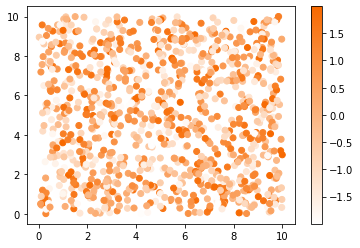

In [52]:
import matplotlib.colors as mcolors

Orange = '#F76900'
Blue = '#000E54'
White = '#FFFFFF'
    
def make_colormap(seq):
    """Return a LinearSegmentedColormap
    seq: a sequence of floats and RGB-tuples. The floats should be increasing
    and in the interval (0,1).
    """
    seq = [(None,) * 3, 0.0] + list(seq) + [1.0, (None,) * 3]
    cdict = {'red': [], 'green': [], 'blue': []}
    for i, item in enumerate(seq):
        if isinstance(item, float):
            r1, g1, b1 = seq[i - 1]
            r2, g2, b2 = seq[i + 1]
            cdict['red'].append([item, r1, r2])
            cdict['green'].append([item, g1, g2])
            cdict['blue'].append([item, b1, b2])
    return mcolors.LinearSegmentedColormap('CustomMap', cdict)


c = mcolors.ColorConverter().to_rgb
rvb = make_colormap([c('#FFFFFF'), c('#F76900')])
N = 1000
array_dg = np.random.uniform(0, 10, size=(N, 2))
colors = np.random.uniform(-2, 2, size=(N,))
plt.scatter(array_dg[:, 0], array_dg[:, 1], c=colors, cmap=rvb)
plt.colorbar()
plt.show()

0.6553062985332183


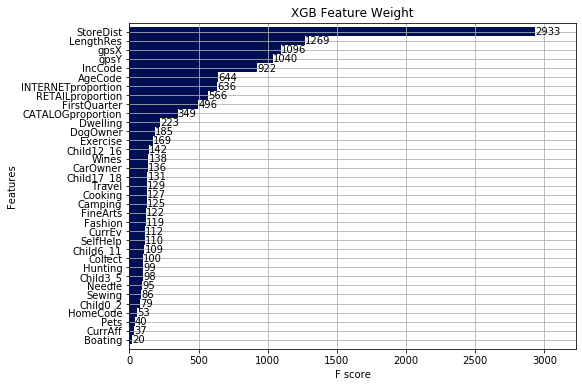

In [53]:
# INCREASING COGS SHARE AND INCREASING RENTENTION COSTS INCREASES PREDICTION ACCURACY
# AcqDate increases accuracy, but is it cheating?
# Can we calculate their favored quarter of shopping?

XGBmodel = XGBClassifier(max_depth = 8)
XGBmodel.fit(train, labeltrain)
preds = XGBmodel.predict(test)
print(XGBmodel.score(test, labeltest))

ax = plot_importance(XGBmodel,  importance_type  = 'weight' , title = 'XGB Feature Weight', color='#000E54', height = 1)
fig = ax.figure
fig.set_size_inches(8, 6)

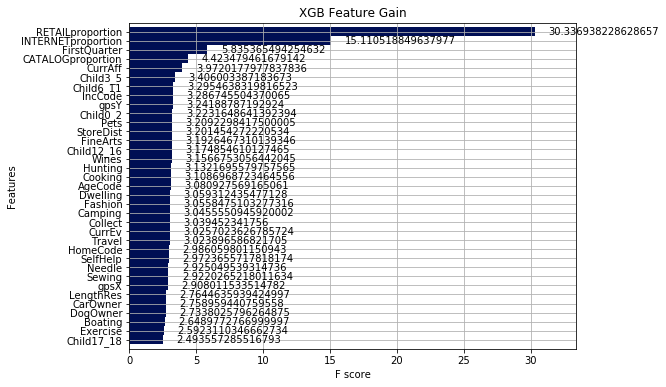

In [54]:
ax = plot_importance(XGBmodel,  importance_type  = 'gain', title = 'XGB Feature Gain', color='#000E54', height = 1)
fig = ax.figure
fig.set_size_inches(8, 6)

Text(0.5, 1, 'Test Dataset Confusion Matrix')

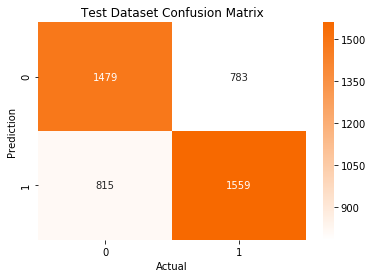

In [55]:
preds = XGBmodel.predict(test)
cf = pd.crosstab(preds, labeltest)
sb.heatmap(cf, annot = True, cmap = rvb, fmt='g')   # center = (max(cf) / 2)
plt.xlabel('Actual')
plt.ylabel('Prediction')
plt.title('Test Dataset Confusion Matrix')

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.762538 to fit


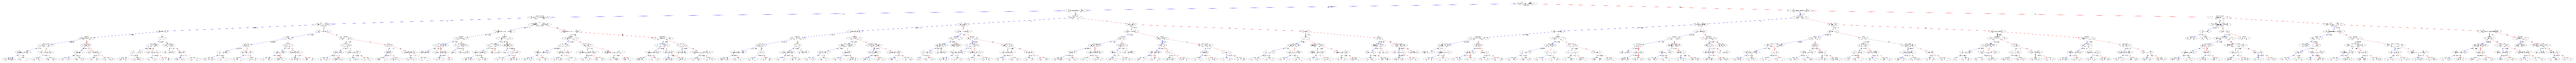

In [56]:
plot_tree(XGBmodel)
fig = plt.gcf()
fig.set_size_inches(150, 75)

In [57]:
#customersfeatures.loc[:,'CLVquintile'] = customersfeatures.loc[:,'CLVestimate']
def customerquintiles(datum):
    quintilelist = []
    q4 = datum.loc[:,'CLVestimate'].quantile(q = 0.8)
    q3 = datum.loc[:,'CLVestimate'].quantile(q = 0.6)
    q2 = datum.loc[:,'CLVestimate'].quantile(q = 0.4)
    q1 = datum.loc[:,'CLVestimate'].quantile(q = 0.2)
    for each in range(0,len(customersfeatures.iloc[:,0])):
        if datum.loc[each,'CLVestimate'] > q4:
            quintilelist.append(4)
        elif datum.loc[each,'CLVestimate'] > q3:
            quintilelist.append(3)
        elif datum.loc[each,'CLVestimate'] > q2:
            quintilelist.append(2)
        elif datum.loc[each,'CLVestimate'] > q1:
            quintilelist.append(1)
        else:
            quintilelist.append(0)
    return quintilelist

quintilelabels = np.array(customerquintiles(customersfeatures))  # to_categorical
print(quintilelabels)

[4 1 0 ... 3 4 4]


In [58]:
clvarray = np.array(customersfeatures.loc[:,['CLVestimate']])

coordinatesdict = {}
for each in range(0,len(clvarray)):
    coordinates = (customersfeatures.loc[each,'gpsX'],customersfeatures.loc[each,'gpsY'])
    if coordinates not in coordinatesdict.keys():
        coordinatesdict[coordinates] = [clvarray[each]]
    else:
        coordinatesdict[coordinates] += [clvarray[each]]

lat = []
long = []
averageclv = []
for each in coordinatesdict.keys():
    x, y = each
    average = sum(coordinatesdict[each]) / len(coordinatesdict[each])
    lat.append(x)
    long.append(y)
    averageclv.append(average)


clvquintiles = []

def assessquintiles(datum):
    if datum > np.quantile(averageclv, .80):
        return 4
    elif datum > np.quantile(averageclv, .60):
        return 3
    elif datum > np.quantile(averageclv, .40):
        return 2
    elif datum > np.quantile(averageclv, .20):
        return 1
    else:
        return 0

for each in averageclv:
    clvquintiles.append(assessquintiles(each))

#standardscaler = StandardScaler()
minmaxscaler = MinMaxScaler()
mapscaledCLV = minmaxscaler.fit_transform(np.reshape(np.array(clvquintiles), (-1, 1)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6365.717420240856
-748.7033804361581


"\nfor a in [100, 300, 500]:\n    plt.scatter([], [], c='k', alpha=0.5, s=a,\n                label=str(a) + ' km$^2$')\nplt.legend(scatterpoints=1, frameon=False,\n           labelspacing=1, loc='lower left')\n"

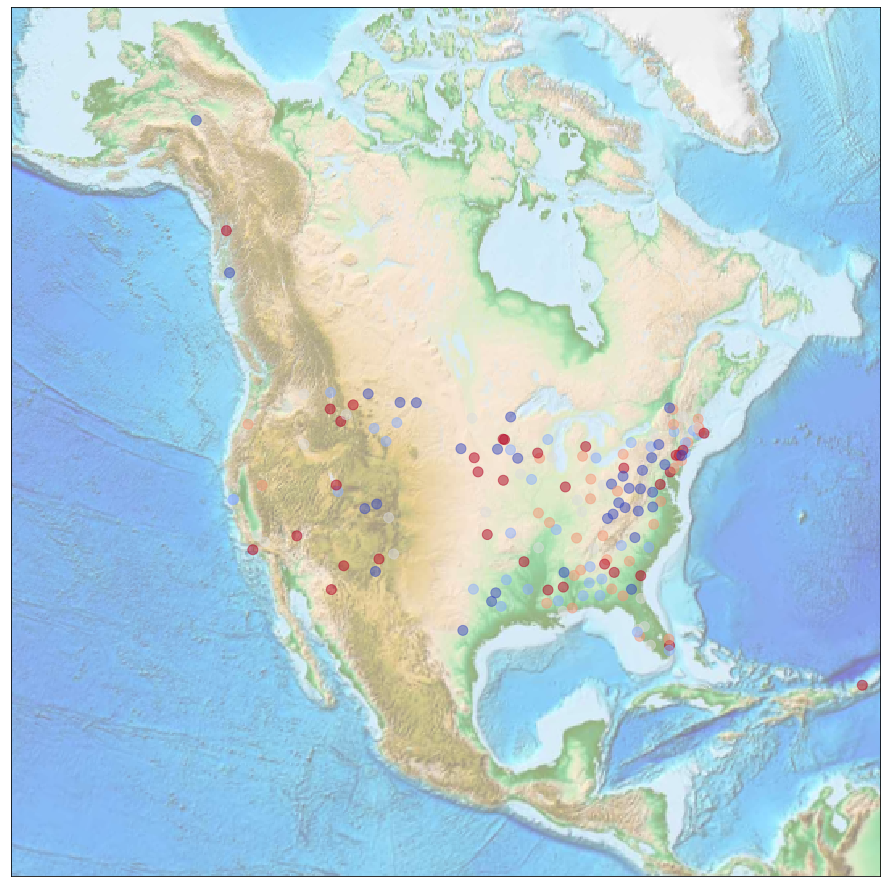

In [59]:
fig = plt.figure(figsize=(16, 16))
m = Basemap(projection='lcc', resolution=None,
            width=8E6, height=8E6, 
            lat_0=45, lon_0=-100,)
m.etopo(scale=0.5, alpha=0.5)


#m.shadedrelief()
#m.drawcoastlines(color='gray')
#m.drawcountries(color='gray')
#m.drawstates(color='gray')


m.scatter(np.reshape(np.array(lat), (-1, 1)), np.reshape(np.array(long), (-1, 1)), latlon=True,
          c = mapscaledCLV,
          cmap='coolwarm', alpha=0.5, s = 100)

# 3. create colorbar and legend
#plt.colorbar(label=r'$\log_{10}({\rm population})$')
#plt.clim(3, 7)

print(max(customersfeatures.loc[:,'CLVestimate']))
print(min(customersfeatures.loc[:,'CLVestimate']))

'''
for a in [100, 300, 500]:
    plt.scatter([], [], c='k', alpha=0.5, s=a,
                label=str(a) + ' km$^2$')
plt.legend(scatterpoints=1, frameon=False,
           labelspacing=1, loc='lower left')
'''

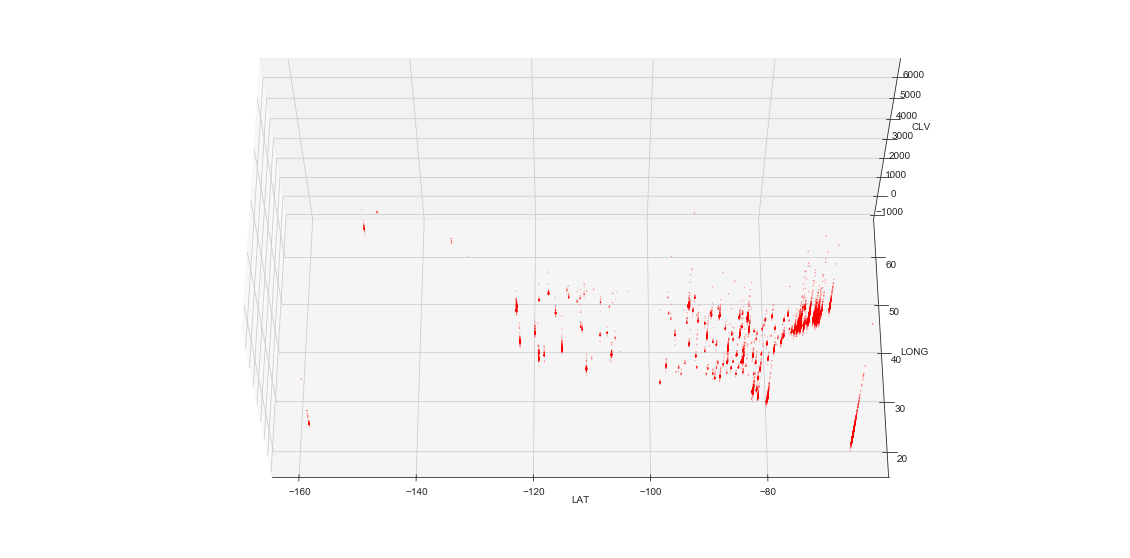

In [60]:
sns.set_style("white")
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(customersfeatures.loc[:,'gpsX'],customersfeatures.loc[:,'gpsY'], customersfeatures.loc[:,'CLVestimate'], s = 0.1, c = 'red', label ='cluster 1' )

ax.set_xlabel("LAT")
ax.set_ylabel("LONG")
ax.set_zlabel("CLV")
ax.view_init(60, 270)
plt.show()